In [1]:
import lightgbm as lgbm
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing, feature_selection, metrics, model_selection, decomposition

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import random
from itertools import product
import pickle

import psutil
import warnings
warnings.filterwarnings('ignore')

idx = pd.IndexSlice

In [2]:
input_directory = Path(r"..\\..\\Data\\Input")

feature_directory = Path(r"..\\..\\Data\\Feature")

model_name = "model_nn_01"
model_directory = Path()/model_name
model_directory.mkdir(exist_ok=True)

In [3]:
def save_pickle(dic, save_path):
    with open(save_path, 'wb') as f:
    # with gzip.open(save_path, 'wb') as f:
        pickle.dump(dic, f)

def load_pickle(load_path):
    with open(load_path, 'rb') as f:
    # with gzip.open(load_path, 'rb') as f:
        message_dict = pickle.load(f)
    return message_dict

### Import Data

In [ ]:
df_data = pd.read_parquet(input_directory/'train_low_mem.parquet', engine='pyarrow').set_index(['time_id','investment_id'])
df_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3141410 entries, (0, 1) to (1219, 3773)
Columns: 302 entries, row_id to f_299
dtypes: float32(301), object(1)
memory usage: 3.6+ GB


In [ ]:
df_data = df_data.drop('row_id', axis=1)
df_data.head()

target       f_0       f_1       f_2       f_3  \
time_id investment_id                                                     
0       1             -0.300875  0.932573  0.113691 -0.402206  0.378386   
        2             -0.231040  0.810802 -0.514115  0.742368 -0.616673   
        6              0.568807  0.393974  0.615937  0.567806 -0.607963   
        7             -1.064780 -2.343535 -0.011870  1.874606 -0.606346   
        8             -0.531940  0.842057 -0.262993  2.330030 -0.583422   

                            f_4       f_5       f_6       f_7       f_8  ...  \
time_id investment_id                                                    ...   
0       1             -0.203938 -0.413469  0.965623  1.230508  0.114809  ...   
        2             -0.194255  1.771210  1.428127  1.134144  0.114809  ...   
        6              0.068883 -1.083155  0.979656 -1.125681  0.114809  ...   
        7             -0.586827 -0.815737  0.778096  0.298990  0.114809  ...   
        8             -0.618392 -0.742814 -0.946789  1.230508  0.114809  ...   

                          f_290     f_291     f_292     f_293     f_294  \
time_id investment_id                                                     
0       1              0.366028 -1.095620  0.200075  0.819155  0.941183   
        2             -0.154193  0.912726 -0.734579  0.819155  0.941183   
        6             -0.138020  0.912726 -0.551904 -1.220772 -1.060166   
        7              0.382201  0.912726 -0.266359 -1.220772  0.941183   
        8             -0.170365  0.912726 -0.741355 -1.220772  0.941183   

                          f_295     f_296     f_297     f_298     f_299  
time_id investment_id                                                    
0       1             -0.086764 -1.087009 -1.044826 -0.287605  0.321566  
        2             -0.387617 -1.087009 -0.929529 -0.974060 -0.343624  
        6             -0.219097 -1.087009 -0.612428 -0.113944  0.243608  
        7             -0.609113  0.104928 -0.783423  1.151730 -0.773309  
        8             -0.588445  0.104928  0.753279  1.345611 -0.737624  

[5 rows x 301 columns]

### Feature Engineering

##### Normalization

In [4]:
# df_data_norm = df_data.copy()

# for i in tqdm(range(300)):
#     feature = f'f_{i}'

#     df_data_norm[feature] = df_data[feature].groupby(level='time_id').apply(
#         lambda x: pd.DataFrame(preprocessing.RobustScaler(quantile_range=(1., 99.), with_scaling=True, with_centering=True).fit_transform(x.values.reshape(-1, 1)), index=x.index, columns=[f'f_{i}']))


# df_data_norm.to_parquet(input_directory/'train_norm2.parquet')
df_data_norm = pd.read_parquet(input_directory/'train_norm2.parquet', engine='pyarrow')

<AxesSubplot:title={'center':'histgram of normalized feature'}, ylabel='Frequency'>

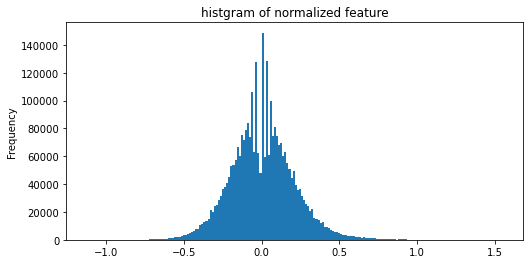

In [5]:
fig = plt.figure(figsize=(18, 4))
# ax = plt.subplot(121)
# df_data['f_1'].plot(kind='hist', bins=200, ax=ax, title="histgram of raw feature")

ax = plt.subplot(122)
df_data_norm['f_1'].plot(kind='hist', bins=200, ax=ax, title="histgram of normalized feature")

### Feature_selection

### Split Feature & target

In [18]:
feature = df_data_norm.filter(like='f_')
target = df_data_norm['target']
# target = target.reset_index(drop=True)
target

time_id  investment_id
0        1               -0.300875
         2               -0.231040
         6                0.568807
         7               -1.064780
         8               -0.531940
                            ...   
1219     3768             0.033600
         3769            -0.223264
         3770            -0.559415
         3772             0.009599
         3773             1.212112
Name: target, Length: 3141410, dtype: float32

In [19]:
# feature = feature.reset_index(drop=True)
feature

f_0       f_1       f_2       f_3       f_4  \
time_id investment_id                                                     
0       1              0.133483  0.025641 -0.107040  0.232203  0.027035   
        2              0.108289 -0.102564  0.160293 -0.011403  0.029314   
        6              0.022050  0.128205  0.119521 -0.009270  0.091237   
        7             -0.544325  0.000000  0.424744 -0.008875 -0.063067   
        8              0.114755 -0.051282  0.531115 -0.003263 -0.070495   
...                         ...       ...       ...       ...       ...   
1219    3768          -0.047359 -0.148677 -0.083344 -0.002532 -0.017038   
        3769          -0.374504 -0.029735 -0.035861 -0.006363 -0.048209   
        3770           0.154132 -0.237883  0.186720 -0.009407 -0.012827   
        3772          -0.652056  0.089206  0.000941  0.435851 -0.010454   
        3773          -0.088998  0.059471 -0.123831  0.139659  0.122948   

                            f_5       f_6       f_7  f_8       f_9  ...  \
time_id investment_id                                               ...   
0       1             -0.084325  0.295687  0.323107  0.0 -0.565489  ...   
        2              0.390865  0.426703  0.295676  0.0 -0.076149  ...   
        6             -0.229989  0.299662 -0.347619  0.0 -0.298825  ...   
        7             -0.171823  0.242565  0.057936  0.0 -0.337304  ...   
        8             -0.155961 -0.246051  0.323107  0.0 -0.017943  ...   
...                         ...       ...       ...  ...       ...  ...   
1219    3768          -0.092924  0.378928  0.318737  0.0 -0.387626  ...   
        3769          -0.029534 -0.402315  0.339488  0.0 -0.329040  ...   
        3770           0.291013  0.030878  0.000000  0.0  0.253357  ...   
        3772          -0.146850  0.091365 -0.286822  0.0 -0.302704  ...   
        3773           0.096628  0.257889 -0.286822  0.0 -0.524376  ...   

                          f_290  f_291     f_292  f_293  f_294     f_295  \
time_id investment_id                                                      
0       1              0.102298   -1.0  0.097949    0.0    0.0  0.049540   
        2             -0.003282    0.0 -0.097370    0.0    0.0 -0.025318   
        6              0.000000    0.0 -0.059196   -1.0   -1.0  0.016613   
        7              0.105580    0.0  0.000476   -1.0    0.0 -0.080431   
        8             -0.006564    0.0 -0.098786   -1.0    0.0 -0.075289   
...                         ...    ...       ...    ...    ...       ...   
1219    3768          -0.080894   -1.0 -0.105754    0.0    0.0 -0.031788   
        3769           0.008933   -1.0 -0.107742    0.0    0.0 -0.107359   
        3770          -0.170720   -1.0  0.191191   -1.0    0.0 -0.015572   
        3772          -0.170720   -1.0  0.053337   -1.0    0.0 -0.018566   
        3773          -0.086849    0.0  0.682466    0.0    0.0  0.032652   

                       f_296     f_297     f_298     f_299  
time_id investment_id                                       
0       1               -0.5 -0.239130 -0.108588  0.119334  
        2               -0.5 -0.209301 -0.285416 -0.006368  
        6               -0.5 -0.127263 -0.063854  0.104602  
        7                0.0 -0.171502  0.262178 -0.087566  
        8                0.0  0.226062  0.312121 -0.080823  
...                      ...       ...       ...       ...  
1219    3768             0.0 -0.063816 -0.096651 -0.068704  
        3769            -0.5  0.039689 -0.294157 -0.070620  
        3770             0.5  0.022208 -0.489768 -0.003278  
        3772            -0.5 -0.147317  0.130867 -0.020435  
        3773             0.5 -0.069543  0.148146  0.170569  

[3141410 rows x 300 columns]

###  Split Train & Test

In [20]:
train_test_ratio = 5

uniquedate = target.index.get_level_values(level='time_id').unique().tolist()
train_start = 0
train_end = uniquedate[int(
    len(uniquedate)*train_test_ratio/(train_test_ratio+1))]
test_start = uniquedate[int(
    len(uniquedate)*train_test_ratio/(train_test_ratio+1))+1]
test_end = 1219


# dates of train, dates of test
print(
    f'train_start: {train_start}, train_end: {train_end}, test_start: {test_start}, test_end: {test_end}')

feature_train = feature.loc[idx[train_start:train_end, :], :]
feature_test = feature.loc[idx[test_start:test_end, :], :]

target_train = target.loc[idx[train_start:train_end, :]]
target_test = target.loc[idx[test_start:test_end, :]]


train_start: 0, train_end: 1018, test_start: 1019, test_end: 1219


In [9]:
def get_train_valid_data(X, y, train_idx, valid_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[valid_idx, :], y.iloc[valid_idx]
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    # x_train = scaler.fit_transform(x_train)
    # x_val = scaler.transform(x_val)
    return (x_train, y_train,
            x_val, y_val)


### Train Model

In [21]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(300, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [22]:
loss_fn = nn.HuberLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [23]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [24]:
n_splits = 2
batch_size = 64

epochs = 5

In [28]:
class UbiquantDataset(Dataset):
    def __init__(self, feature, target):
        self.feature = torch.tensor(feature.values)
        self.target = torch.tensor(target.values)

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        # feature = torch.tensor(self.feature.iloc[idx, :])
        # target = torch.tensor(self.target.iloc[idx])
        return self.feature[idx, :], self.target[idx]


# train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
# dataloader = DataLoader(UbiquantDataset(feature_train, target_train), batch_size=64, shuffle=True)
# dataloader


In [30]:
cv = model_selection.KFold(
    n_splits=n_splits, random_state=2021, shuffle=True)

for i, (train_idx, valid_idx) in enumerate(cv.split(X=feature_train)):
    print("##############################################################")
    print(f"cv: {i+1}")

    X_train, y_train, X_valid, y_valid = get_train_valid_data(
        feature_train, target_train, train_idx, valid_idx)

    train_dataloader = DataLoader(UbiquantDataset(
        X_train, y_train), batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(UbiquantDataset(
        X_valid, y_valid), batch_size=batch_size, shuffle=True)

    for t in range(epochs):
        print("-------------------------------------------------")
        print(f"Epoch: {t+1}")
        train(train_dataloader, model, loss_fn, optimizer)
        test(valid_dataloader, model, loss_fn)


##############################################################
cv: 1
-------------------------------------------------
Epoch: 1
loss: 0.418208  [    0/1245446]
loss: 0.262168  [ 6400/1245446]
loss: 0.237383  [12800/1245446]
loss: 0.243403  [19200/1245446]
loss: 3.286797  [25600/1245446]
loss: 2.648721  [32000/1245446]
loss: 0.275080  [38400/1245446]
loss: 0.420341  [44800/1245446]
loss: 0.334350  [51200/1245446]
loss: 8.527649  [57600/1245446]
loss: 1883.900269  [64000/1245446]
loss: 1.000248  [70400/1245446]
loss: 0.511916  [76800/1245446]
loss: 0.327506  [83200/1245446]
loss: 0.352686  [89600/1245446]
loss: 0.295097  [96000/1245446]
loss: 0.412521  [102400/1245446]
loss: 0.409077  [108800/1245446]
loss: 0.213738  [115200/1245446]
loss: 0.377543  [121600/1245446]
loss: 0.479487  [128000/1245446]
loss: 0.381072  [134400/1245446]
loss: 0.241106  [140800/1245446]
loss: 0.249520  [147200/1245446]
loss: 0.378443  [153600/1245446]
loss: 0.302384  [160000/1245446]
loss: 0.274072  [166400/124

KeyboardInterrupt: 